In [1]:
import sys
import os

# Get the absolute path of the project root
project_root = os.path.abspath("..")  # Adjust if necessary

# Add to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)


In [2]:
import sys
print(sys.executable)

/Users/cesarlindberg/anaconda3/envs/cardiac_pinn/bin/python


DataFrame shape: (132651, 5)
                   x              y              z              T    sim_id
count  132651.000000  132651.000000  132651.000000  132651.000000  132651.0
mean        0.500000       0.500000       0.500000       0.544120       1.0
std         0.294377       0.294379       0.294335       0.178907       0.0
min         0.000000       0.000000       0.000000       0.000000       1.0
25%         0.240000       0.240000       0.240000       0.415100       1.0
50%         0.500000       0.500000       0.500000       0.560300       1.0
75%         0.760000       0.760000       0.760000       0.676700       1.0
max         1.000000       1.000000       1.000000       0.993000       1.0
Missing values:
 x         0
y         0
z         0
T         0
sim_id    0
dtype: int64


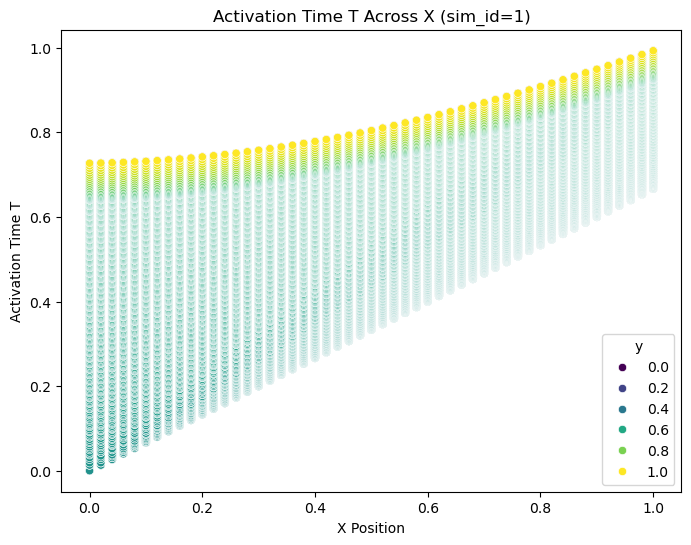

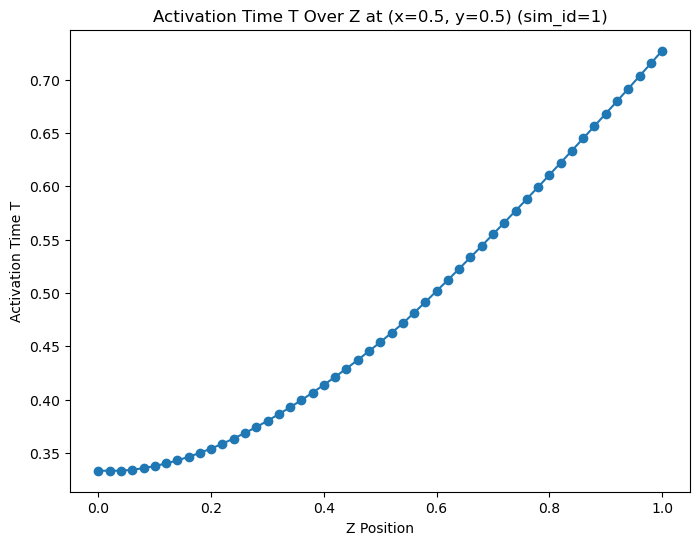

In [3]:
# Debugging code for loading and visualizing the spatial activation data.
from src.training.pinnex_data_loader import load_spatiotemp_df
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the spatial parquet file which now contains columns: [x, y, z, T, sim_id]
df = load_spatiotemp_df("../data/synthetic/parsed/spatio_EIK_vol0.parquet")
print("DataFrame shape:", df.shape)

# Create a DataFrame for inspection
df_debug = pd.DataFrame({
    "x": df["x"],
    "y": df["y"],
    "z": df["z"],
    "T": df["T"],
    "sim_id": df["sim_id"]
})

# Summary statistics
print(df_debug.describe())

# Check for missing values
print("Missing values:\n", df_debug.isnull().sum())

# Sample plot: Activation time T across x, colored by y
# Pick a representative sim_id to visualize (e.g., the first one)
sim_id_to_plot = df_debug["sim_id"].unique()[0]
df_sim = df_debug[df_debug["sim_id"] == sim_id_to_plot]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_sim["x"], y=df_sim["T"], hue=df_sim["y"], palette="viridis")
plt.title(f"Activation Time T Across X (sim_id={sim_id_to_plot})")
plt.xlabel("X Position")
plt.ylabel("Activation Time T")
plt.show()

# Another plot: Activation time T vs. depth z at a fixed x-y location
x_fixed, y_fixed = df_sim["x"].median(), df_sim["y"].median()
df_fixed_xy = df_sim[(df_sim["x"] == x_fixed) & (df_sim["y"] == y_fixed)]

plt.figure(figsize=(8, 6))
plt.plot(df_fixed_xy["z"], df_fixed_xy["T"], marker='o')
plt.title(f"Activation Time T Over Z at (x={x_fixed}, y={y_fixed}) (sim_id={sim_id_to_plot})")
plt.xlabel("Z Position")
plt.ylabel("Activation Time T")
plt.show()


In [4]:
# Debugging code for the new PINN model (eikonal version)
from src.networks.pinnex_models import PINNWithECG
import torch

# Instantiate the new model
model = PINNWithECG()

# Create dummy spatial input: (x, y, z) of shape (batch_size, 1) each
batch_size = 10
x = torch.rand(batch_size, 1)
y = torch.rand(batch_size, 1)
z = torch.rand(batch_size, 1)

# Create a dummy ECG tensor of shape (batch_size, n_leads, seq_len)
n_leads = 12
seq_len = 1000
ecg = torch.rand(batch_size, n_leads, seq_len)

# Forward pass: model now predicts activation time T and conduction velocity c
T_pred, c_pred = model(x, y, z, ecg)
print("Activation time T shape:", T_pred.shape)  # Expected: (10, 1)
print("Conduction velocity c shape:", c_pred.shape)  # Expected: (10, 1)


Activation time T shape: torch.Size([10, 1])
Conduction velocity c shape: torch.Size([10, 1])


In [5]:
# Debugging code for checking the eikonal residual with a trivial solution
import torch
from src.networks.pinnex_models import PINNWithECG
from src.networks.pinn_wrapper import CachedPINNWrapper
from src.pde.eikonal_pinnex import check_eikonal_residual_with_trivial_solution

# Define PDE parameters for the eikonal equation (conduction velocity)
params = {
    'c': 0.6  # conduction velocity (units consistent with T and spatial coordinates)
}

# Check if the residual is near zero using a trivial solution that satisfies |∇T| = 1/c
residual = check_eikonal_residual_with_trivial_solution(
    model_class=PINNWithECG,
    model_wrapper=CachedPINNWrapper,
    params=params
)


Mean(|residual|): 7.631392e-01


In [9]:
import torch
from src.networks.pinnex_models import PINNWithECG
from src.training.trainer_pinnex import train_pinnex_minibatch_with_ecg

# 1) Create small synthetic data
# Suppose we have 5 data points for spatial coordinates and activation time T.
x_data = torch.linspace(0, 1, 5).view(-1, 1)
y_data = torch.zeros_like(x_data)
z_data = torch.zeros_like(x_data)
T_data = torch.linspace(0, 1, 5).view(-1, 1)  # synthetic activation times

# Create dummy ECG data for each data point (shape: [batch_size, n_leads, seq_len])
n_leads = 12
seq_len = 1000
ecg_data = torch.zeros(x_data.size(0), n_leads, seq_len)

# Simulated sim_ids for each sample (here, all set to 0)
sim_ids = torch.zeros(x_data.size(0), dtype=torch.int32)

# For this debug, we'll pack the data into a TensorDataset and DataLoader.
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(x_data, y_data, z_data, ecg_data, T_data, sim_ids)
# Use the same dataset for validation for debugging purposes.
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=5, shuffle=False)

# 2) Physics collocation points (spatial only, since our PDE encoder uses x, y, z)
N_phys = 10
x_phys = torch.rand(N_phys, 1)
y_phys = torch.rand(N_phys, 1)
z_phys = torch.rand(N_phys, 1)
# (coords_phys is generated inside the trainer based on training data bounds)

# 3) PDE parameters for the eikonal equation
params = {
    'c': 0.6  # conduction velocity
}

# 4) Initialize model and (optional) wrapper for caching ECG encodings
model = PINNWithECG(
    pde_hidden_architecture=[16, 16, 16],
    ecg_hidden_architecture=[128],
    decoder_hidden_architecture=[64, 64]
)
from src.networks.pinn_wrapper import CachedPINNWrapper
wrapper = CachedPINNWrapper(model)

# 5) Train the model using the eikonal PINN trainer
loss_hist, val_hist, data_hist, physics_hist = train_pinnex_minibatch_with_ecg(
    wrapper=wrapper,
    train_loader=train_loader,
    val_loader=val_loader,
    params=params,
    n_epochs=5000,
    lr=1e-3,
    physics_weight=1e-4,
    device='cpu'
)

# 6) Check final loss values
print("Final total loss:", loss_hist[-1])
print("Final data loss :", data_hist[-1])
print("Final PDE loss  :", physics_hist[-1])


[Epoch 1/5000] Train Loss: 8.8795e-02 | Data Loss: 8.8795e-02 | PDE Loss: 8.2917e-01
[Epoch 2/5000] Train Loss: 8.8833e-02 | Data Loss: 8.8833e-02 | PDE Loss: 7.8014e-01
[Epoch 3/5000] Train Loss: 7.6790e-02 | Data Loss: 7.6790e-02 | PDE Loss: 7.3191e-01
[Epoch 4/5000] Train Loss: 9.2741e-02 | Data Loss: 9.2741e-02 | PDE Loss: 6.7566e-01
[Epoch 5/5000] Train Loss: 8.7900e-02 | Data Loss: 8.7900e-02 | PDE Loss: 6.3306e-01 | Val Loss: 5.8362e-02
[Epoch 6/5000] Train Loss: 5.6710e-02 | Data Loss: 5.6710e-02 | PDE Loss: 6.0905e-01
[Epoch 7/5000] Train Loss: 6.0235e-02 | Data Loss: 6.0235e-02 | PDE Loss: 5.9203e-01
[Epoch 8/5000] Train Loss: 1.1519e-01 | Data Loss: 1.1519e-01 | PDE Loss: 5.5312e-01
[Epoch 9/5000] Train Loss: 8.3429e-02 | Data Loss: 8.3429e-02 | PDE Loss: 5.2228e-01
[Epoch 10/5000] Train Loss: 5.0974e-02 | Data Loss: 5.0974e-02 | PDE Loss: 4.9569e-01 | Val Loss: 3.0995e-02
[Epoch 11/5000] Train Loss: 3.5374e-02 | Data Loss: 3.5374e-02 | PDE Loss: 4.7304e-01
[Epoch 12/5000] T